In [1]:
import pickle
import strip
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
TILE_SIZE = 20

In [3]:
## Loading
recover = open('./test.p', 'rb')
input_list = pickle.load(recover)
print(len(input_list))

174257


In [4]:
cancer_cells = []
T_cells = []
cyto_T_cells = []

for i, row in enumerate(input_list):
    row = [ int(x) for x in row ]
    
    if row[4] > 0:
        cancer_cells.append([row[0], row[1], row[2], row[3]])
    if row[5] > 0:
        T_cells.append([row[0], row[1], row[2], row[3]])
    if row[6] > 0:
        cyto_T_cells.append([row[0], row[1], row[2], row[3]])
        
cancer_cells = np.asarray(cancer_cells)
T_cells = np.asarray(T_cells)
cyto_T_cells = np.asarray(cyto_T_cells)

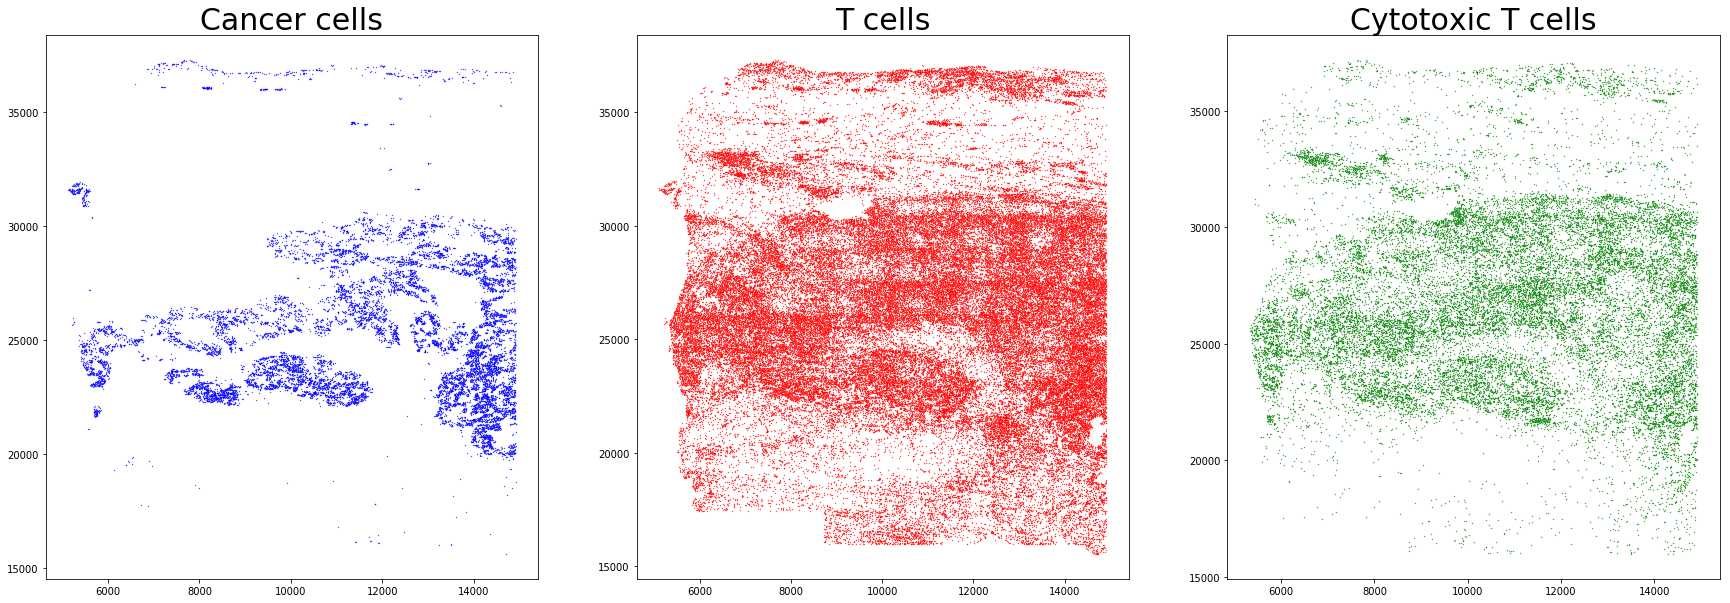

In [17]:
cancer_cells_xAvg = np.mean(np.array([cancer_cells[:,0], cancer_cells[:,1]]), axis=0)
cancer_cells_yAvg = np.mean(np.array([cancer_cells[:,2], cancer_cells[:,3]]), axis=0)

T_cells_xAvg = np.mean(np.array([T_cells[:,0], T_cells[:,1]]), axis=0)
T_cells_yAvg = np.mean(np.array([T_cells[:,2], T_cells[:,3]]), axis=0)

cyto_T_cells_xAvg = np.mean(np.array([cyto_T_cells[:,0], cyto_T_cells[:,1]]), axis=0)
cyto_T_cells_yAvg = np.mean(np.array([cyto_T_cells[:,2], cyto_T_cells[:,3]]), axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

ax1.set_title('Cancer cells', fontsize=30)
ax1.scatter(cancer_cells_xAvg, cancer_cells_yAvg, s=0.1, c='b')

ax2.set_title('T cells', fontsize=30)
ax2.scatter(T_cells_xAvg, T_cells_yAvg, s=0.1, c='r')

ax3.set_title('Cytotoxic T cells', fontsize=30)
ax3.scatter(cyto_T_cells_xAvg, cyto_T_cells_yAvg, s=0.1, c='g')

plt.show(fig)
print

In [6]:
# output_image = np.zeros((220, 100), dtype=np.int)
# output_image = np.uint8(np.stack((output_image, output_image, output_image), 2)*255)

In [7]:
# import cv2

# def visualise_tiles(image, num_tiles, draw_image):
#     xMin = image[:,0]
#     xMax = image[:,1]
#     yMin = image[:,2]
#     yMax = image[:,3]

#     # Just scaling this down so that we don't have to work with ENORMOUS images
#     x_step = int(((max(xMax) / 10) - (min(xMin) / 10)) // (num_tiles * 10))
#     y_step = int(((max(yMax) / 10) - (min(yMin) / 10)) // (num_tiles * 10))
        
#     for i in range(num_tiles):
#         for j in range(num_tiles):
#             x_left, y_left = x_step * i, y_step * (j + 1)
#             x_right, y_right = x_step * (i + 1), y_step * j
#             cv2.rectangle(draw_image, (x_left, y_left), (x_right, y_right), (255, 255, 0), 1)
    
#     return draw_image

# copy1 = np.copy(output_image)
# copy2 = np.copy(output_image)
# copy3 = np.copy(output_image)

# out1 = visualise_tiles(cancer_cells, 20, copy1)
# out2 = visualise_tiles(cancer_cells, 10, copy2)
# out3 = visualise_tiles(cancer_cells, 5, copy3)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))

# ax1.imshow(out1)
# ax2.imshow(out2)
# ax3.imshow(out3)

# plt.show()

In [8]:
import partition

partitioned_cancer_cells, windows = partition.partition(cancer_cells)
# partitioned_cancer_cells, windows = partition.partition_and_visualise(cancer_cells)

In [9]:
import Cluster
# import Current_Cluster
import cProfile

In [10]:
# Example cases for clustering algorithm

In [11]:
# NUM_POINTS = 100

# check_again = False

# if not check_again:
# #     random_xMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
# #     random_xMax = np.copy(random_xMin) + 3
# #     random_yMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
# #     random_yMax = np.copy(random_yMin) + 3
#     random_xMin = np.array([0, 15, 31, 30, 60, 0,  30, 60, 0,  30, 60])
#     random_xMax = np.array([3, 26, 33, 33, 63, 3,  33, 63, 3,  33, 63])
#     random_yMin = np.array([0, 8,  8,  0,  0,  30, 30, 30, 60, 60, 60])
#     random_yMax = np.array([3, 12, 12, 3,  3,  33, 33, 33, 63, 63, 63])
#     random_points = np.stack((random_xMin, random_xMax, random_yMin, random_yMax), 0).transpose()

# t = 3
# partitioned_random_points, windows_list = partition.partition(random_points, tile_size=t)
# flattened_windows_list = np.array(windows_list).reshape((t*t, 4))
# print(flattened_windows_list)

# partitioned_total = 0
# for i in range(t):
#     for j in range(t):
#         partitioned_total += partitioned_random_points[i][j].shape[0]

# # assert(partitioned_total == NUM_POINTS)

# fig = plt.figure()

# ax1 = fig.add_subplot(111, aspect='equal')

# ax1.scatter(random_points[:,0], random_points[:,2], s=5, c='g')
# ax1.scatter(random_points[:,1], random_points[:,3], s=5, c='b')

# for window in flattened_windows_list:
#     xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
#     ax1.add_patch(
#         patches.Rectangle(
#             (xMin, yMin),   # (x,y)
#             xMax - xMin,    # width
#             yMax - yMin,    # height
#             linestyle='--',
#             fill=False
#         )
#     )

# plt.show()

# # Current_Cluster_result = Current_Cluster.window_cleaning_algorithm(partitioned_random_points, t, windows_list)
# Cluster_result = Cluster.window_cleaning_algorithm(partitioned_random_points, t, windows_list)

# print(Cluster_result)
# print()
# # print(Current_Cluster_result)

# dups = set()
# histogram = np.zeros(21, dtype=np.uint32)

# for i in range(t):
#     for j in range(t):
#         for key, value in Cluster_result[i][j].items():
#             if value not in dups:
#                 dups.add(value)
        
# print("dups (length is %d):" % len(dups))
# total_cluster_cells = 0
# for i in dups:
#     print(i, " ***")
#     if i is None:
#         raise TypeError
#     value = len(i.cells)
#     total_cluster_cells += len(i.cells)
#     if value > 20:
#         histogram[20] += 1
#     else:
#         histogram[value - 1] += 1

# print(total_cluster_cells)
# print(histogram)

# for cluster in dups:
#     cluster_points_xMin = np.array([item[0] for item in cluster.cells])
#     cluster_points_xMax = np.array([item[1] for item in cluster.cells])
#     cluster_points_yMin = np.array([item[2] for item in cluster.cells])
#     cluster_points_yMax = np.array([item[3] for item in cluster.cells])
#     print("cluster", cluster, ".length: ", len(cluster.cells))

#     fig = plt.figure()
#     ax1 = fig.add_subplot(111, aspect='equal')

#     ax1.scatter(cluster_points_xMin, cluster_points_yMin, s=5, c="b")
#     ax1.scatter(cluster_points_xMax, cluster_points_yMax, s=5, c="b")

#     for window in flattened_windows_list:
#         xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
#         ax1.add_patch(
#             patches.Rectangle(
#                 (xMin, yMin),   # (x,y)
#                 xMax - xMin,    # width
#                 yMax - yMin,    # height
#                 linestyle='--',
#                 fill=False
#             )
#         )
#     plt.show()

In [12]:
t = 20
partitioned_cancer_cells, windows = partition.partition(cancer_cells)
print("cells partitioned ...")

cells partitioned ...


In [14]:
result = Cluster.window_cleaning_algorithm(partitioned_cancer_cells, t, windows)
print("result retrieved...")

result retrieved...


In [ ]:
# cProfile.run("Current_Cluster.window_cleaning_algorithm(partitioned_cancer_cells, t, windows)")
# print("###################################################################")
# print("###################################################################")
# print("###################################################################")
# cProfile.run("Cluster.window_cleaning_algorithm(partitioned_random_points, 3, windows_list)")

In [16]:
tile_numbers = []
dups = []
histogram = np.zeros(21, dtype=np.uint32)

for i in range(t):
    for j in range(t):
        num = 0
        for key, value in result[i][j].items():
            if value not in dups:
                dups.append(value)
            num += 1
        tile_numbers.append(num)
        
print("dups (length is %d):" % len(dups))
total_cluster_cells = 0

clusters_sum = 0
dups_length = len(dups)

for i in dups:
    value = len(i.cells)
    clusters_sum += value
    total_cluster_cells += len(i.cells)
    if value > 20:
        histogram[20] += 1
    else:
        histogram[value - 1] += 1
                
clusters_avg = clusters_sum / dups_length

print("Total number of cells:", total_cluster_cells)

print(histogram)
    
y = np.array(histogram)
x = np.arange(21) + 1

fig = plt.figure()

fig.bar(x, y)
fig.xlabel("Value")
fig.ylabel("Frequency")
fig.show()

y = np.array([1838, 817, 467, 324, 223, 172, 13, 80, 79, 61, 42, 29, 21, 20, 8, 7, 11, 8, 6, 6, 18])

plt.bar(x, y)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# for cluster in dups:
#     cluster_points_xMin = np.array([item[0] for item in cluster.cells])
#     cluster_points_xMax = np.array([item[1] for item in cluster.cells])
#     cluster_points_yMin = np.array([item[2] for item in cluster.cells])
#     cluster_points_yMax = np.array([item[3] for item in cluster.cells])
#     print("cluster", cluster, ".length: ", len(cluster.cells))

#     fig = plt.figure()
#     ax1 = fig.add_subplot(111, aspect='equal')

#     ax1.scatter(cluster_points_xMin, cluster_points_yMin, s=5, c="b")
#     ax1.scatter(cluster_points_xMax, cluster_points_yMax, s=5, c="b")

#     for window in windows_list:
#         xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
#         ax1.add_patch(
#             patches.Rectangle(
#                 (xMin, yMin),   # (x,y)
#                 xMax - xMin,    # width
#                 yMax - yMin,    # height
#                 linestyle='--',
#                 fill=False
#             )
#         )
#     plt.show()

dups (length is 2644):
Total number of cells: 13804
[1275  444  223  138   89   68   51   49   30   22   21   17   16   15   10
   17   12    9    7   13  118]


AttributeError: 'Figure' object has no attribute 'bar'

In [ ]:
test_tile_size = 3

# Should have neighbours in (0, 0) and (1, 1) between [15, 24, 8, 12] and [31, 33, 8, 12] respectively.
# First, let's show they are neighbours.
a = np.array([15, 26, 8, 12])
b = np.array([31, 33, 8, 12])
assert(Current_Cluster.are_neighbours(a, b) and Current_Cluster.are_neighbours(b, a))

# BUT
# BUT
# BUT
# b cannot reach tile (0, 0), whereas a can reach tile (1, 0)
first_window = np.array([0, 22, 0, 22])
second_window = np.array([22, 44, 0, 22])
assert(not (Current_Cluster.are_neighbours(b, first_window) or Current_Cluster.are_neighbours(first_window, b)))
assert(Current_Cluster.are_neighbours(a, second_window) and Current_Cluster.are_neighbours(second_window, a))

# xMinOk = (xMin1 - width) < xMin2
# xMaxOk = xMax2 < (xMax1 + width)
# yMinOk = (yMin1 - height) < yMin2
# yMaxOk = yMax2 < (yMax1 + height)

# Also, [31, 33, 8, 12] has a neighbour in its own tile, being [30, 33, 0, 3]
c = np.array([30, 33, 0, 3])
assert(Current_Cluster.are_neighbours(b, c) and Current_Cluster.are_neighbours(c, b))

xMin = np.array([0, 15, 31, 30, 60, 0,  30, 60, 0,  30, 60])
xMax = np.array([3, 26, 33, 33, 63, 3,  33, 63, 3,  33, 63])
yMin = np.array([0, 8,  8,  0,  0,  30, 30, 30, 60, 60, 60])
yMax = np.array([3, 12, 12, 3,  3,  33, 33, 33, 63, 63, 63])

points = np.stack((xMin, xMax, yMin, yMax), 0).transpose()
partitioned_points, windows = partition.partition(points, tile_size=test_tile_size, load_bar=False)
flattened_windows_list = np.array(windows).reshape((test_tile_size*test_tile_size, 4))
print(flattened_windows_list)

fig = plt.figure()

ax1 = fig.add_subplot(111, aspect='equal')

ax1.scatter(points[:,0], points[:,2], s=5, c='g')
ax1.scatter(points[:,1], points[:,3], s=5, c='b')

for window in flattened_windows_list:
    xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
    ax1.add_patch(
        patches.Rectangle(
            (xMin, yMin),   # (x,y)
            xMax - xMin,    # width
            yMax - yMin,    # height
            linestyle='--',
            fill=False
        )
    )

plt.show()

# Finally, b ONLY has two neighbours. Let's prove it.
num_neighbours = 0
for i in range(test_tile_size):
    for j in range(test_tile_size):
        tile = partitioned_points[i][j]
        for cell in tile:
            if Current_Cluster.are_neighbours(b, cell) and not np.array_equal(b, cell):
                num_neighbours += 1

assert(num_neighbours == 2)

neighbouring_windows, neighbouring_indices = Current_Cluster.get_neighbouring_windows(0, 0, test_tile_size, windows)

# The order of traversal matters, so let's just rearrange the two points in tile (1, 1), which are [25, 28, 24, 27] and [30, 33, 30, 33], for the sake of this test.
temp = partitioned_points[1][1][0]
partitioned_points[1][1][0] = partitioned_points[1][1][1]
partitioned_points[1][1][1] = temp

neighbours = Current_Cluster.get_all_neighbours(b, partitioned_points, 0, (1, 1), neighbouring_windows, neighbouring_indices)

# Gets neighbours in own cell first
expected_cells, expected_tiles = [np.array([30, 33, 30, 33]), np.array([16, 19, 15, 18])], [(1, 1), (0, 0)]
actual_cells, actual_tiles = [], []

for neighbour, tile in neighbours:
    actual_cells.append(neighbour)
    actual_tiles.append(tile)

assert(len(actual_cells) == 2 and len(actual_tiles) == 2)

for cell1, cell2, tile1, tile2 in zip(expected_cells, actual_cells, expected_tiles, actual_tiles):
    assert(np.array_equal(cell1, cell2))
    assert(tile1 == tile2)